## 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기


### 라이브러리 IMPORT

In [1]:
import tensorflow as tf 
import konlpy
import gensim
from konlpy.tag import Mecab
from collections import Counter

import os,sys,copy,time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
import re

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


### 1. 데이터 준비와 확인

##### (1) 데이터 load

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train_data",train_data.head(),train_data.shape)
print('-'*60)
print("test_data",test_data.head(),test_data.shape)

train_data          id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1 (150000, 3)
------------------------------------------------------------
test_data         id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0 (50000, 3)


##### (2) 데이터 정제연습 셀: 아래 함수에 넣기위한  사전 테스트

In [3]:
## 데이터 정제연습: 수시로 필요시

test_need = False 

if test_need:
    # 이상문자 유무체크:
    print("전체문장 결합후 한개의 리스트로 전환",  ' '.join(train_data['document'].astype(str).tolist()))
    m=re.findall('[a-zA-Z]+ | -+',' '.join(train_data['document'].astype(str).tolist()))
    print(m)

    # 데이터 정제연습
    train_data['document'].str.replace("[' ']+"," ")
    train_data['document'].str.replace("\.{2,30}"," ") 
    train_data['document'].str.replace("[^ㄱ-힣 \S+ !?\^+]","")
    train_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","") 
    train_data['document'].str.replace("[^!?.,\^]","")
    print("연습대상 제거상태_train_data.head()",train_data.head())
   

### 2. 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

데이터의 중복 제거 /  NaN 결측치 제거 / 한국어 토크나이저로 토큰화 / 불용어(Stopwords) 제거 / 사전word_to_index 구성 / 텍스트 스트링을 사전 인덱스 스트링으로 변환


#### (1) 데이터로더 함수 생성 및 데이터 return

In [4]:
## 데이터로더
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words=10000

def load_data(train_data, test_data, num_words=num_words):
    ## 중복값 제거:  'document'컬럼의 중복값 제거,'label'컬럼은 0,1의 두개면 맞음
    #1. train_data
    print("train_data['document'].nunique()",train_data['document'].nunique())
    if train_data['document'].nunique() < len(train_data):
        train_data.drop_duplicates(subset=['document'], inplace=True) 
        print("train_data['label'].nunique()",train_data['label'].nunique())    
        print("중복제거후 len(train_data)",len(train_data))    
    #2. test_data    
    print("test_data['document'].nunique()",test_data['document'].nunique())
    if test_data['document'].nunique() < len(test_data):
        test_data.drop_duplicates(subset=['document'], inplace=True)
        print("test_data['label'].nunique()",test_data['label'].nunique())    
        print("중복제거후 len(test_data)",len(test_data))
    
    ## 결측치제거 : 1개라도 있으면, 해당행 전체 제거
    #1. train_data
    print("결측치 개수",train_data.isnull().sum())
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",train_data.isnull().any().any())    
    #2. test_data
    print("결측치 개수",test_data.isnull().sum())
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
        print("결측치제거후 결측치 여부",test_data.isnull().any().any())
    
    ## 데이터 정제 
    # 한글과 숫자,공백(한개이상 공백은 한개로 축소),특수문자일부 !?,.^을 제외하고 제거:[^ㄱ-힣a-zA-Z0-9!?,.^\s]
    # --> 한글형태소기를 tokenizer로 쓸 경우에는 영어및 일부선택된 특수문자외에는 모두제거(..., - - 등도 제거)
    #1. train_data
    train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
    train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ") 
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                         
    print("한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()",train_data.head())
    #2. test_data
    test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
    test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ") 
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외
    #test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣a-zA-Z0-9!?,.^\s]","")  #한글영어병행형태소기인경우 영어포함                                                            
    print("한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()",test_data.head())
    # 데이터 정제후 빈 공백만 있는 문장의 경우 제거:  Nan 입력후 행제거
    #1. train_data
    train_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",train_data.isnull().any().any() )
    if train_data.isnull().any().any():
        train_data.dropna(how='any',inplace=True)
    #2. test_data   
    test_data['document'].replace('', np.nan, inplace=True)
    print("Nan 존재유뮤",test_data.isnull().any().any() )
    if test_data.isnull().any().any():
        test_data.dropna(how='any',inplace=True)
    
    ## 한국어 토크나이저로 토큰화    
    # 1. train_data
    X_train = []
    for sentence in tqdm.tqdm(train_data['document']):
        tokenized = tokenizer.morphs(sentence) # morphs 형태소추출
        #print("tokenized", tokenized)
        tokenized_without_stopwords = [word for word in tokenized if not word in stopwords] # 불용어 제거
        X_train.append(tokenized_without_stopwords)
    print("X_train",X_train[:5],len(X_train))
    
    # 2. test_data
    X_test = []
    for sentence in tqdm.tqdm(test_data['document']):
        tokenized = tokenizer.morphs(sentence) # morphs 형태소추출
        #print("tokenized", tokenized)
        tokenized_without_stopwords = [word for word in tokenized if not word in stopwords] # 불용어 제거
        X_test.append(tokenized_without_stopwords)
    print("X_test",X_test[:5],len(X_test))
    
    ## word_to_index 구성: train only ???  train + test ??? 로 word vs index 매칭 ??? !!!!!!!!!!!!
    words = np.concatenate(X_train).tolist()  
    #words = np.concatenate(X_train).tolist() + np.concatenate(X_test).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)   #10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    ## X_Train, X_test 를 word_to_index의 index로 mapping
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 인덱스로 매칭된 데이터 확인
print("X_train[:5]",X_train[:5],"y_train[:5]",y_train[:5],"X_test[:5]",X_test[:5],"y_test[:5]",y_test[:5])
print('len( word_to_index)', len(word_to_index))


train_data['document'].nunique() 146182
train_data['label'].nunique() 2
중복제거후 len(train_data) 146183
test_data['document'].nunique() 49157
test_data['label'].nunique() 2
중복제거후 len(test_data) 49158
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False
결측치 개수 id          0
document    1
label       0
dtype: int64
결측치제거후 결측치 여부 False


/tmp/ipykernel_6015/3857769262.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_6015/3857769262.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_6015/3857769262.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_train_data.head()          id                                           document  label
0   9976970                                 아 더빙  진짜 짜증나네요 목소리      0
1   3819312                       흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                        교도소 이야기구먼  솔직히 재미는 없다 평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


/tmp/ipykernel_6015/3857769262.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document' ]= test_data['document'].str.replace("[' ']+"," ")
/tmp/ipykernel_6015/3857769262.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("\.{2,30}"," ")
/tmp/ipykernel_6015/3857769262.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-힣0-9!?,.\^+ ^\s]","")  #한글전용형태소기인 경우 영어제외


한글과 공백,기타일부 등제외후 모두제거상태_test_data.head()         id                                        document  label
0  6270596                                             굳 ㅋ      1
1  9274899                                                      0
2  8544678             뭐야 이 평점들은  나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                     지루하지는 않은데 완전 막장임  돈주고 보기에는       0
4  6723715  3만 아니었어도 별 다섯 개 줬을텐데  왜 3로 나와서 제 심기를 불편하게 하죠??      0
Nan 존재유뮤 True
Nan 존재유뮤 True


100%|██████████| 146026/146026 [00:13<00:00, 10991.10it/s]


X_train [['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '!', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다']] 146026


100%|██████████| 49084/49084 [00:04<00:00, 11017.13it/s]


X_test [['굳', 'ㅋ'], ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '10', '점', '짜리', '더더욱', '아니', '잖아'], ['지루', '하', '지', '않', '은데', '완전', '막장', '임', '돈', '주', '고', '보', '기'], ['3', '만', '아니', '었', '어도', '별', '다섯', '개', '줬', '을', '텐데', '왜', '3', '로', '나와서', '제', '심기', '불편', '하', '게', '하', '죠', '?', '?'], ['음악', '주', '된', ',', '최고', '음악', '영화']] 49084
X_train[:5] [[31, 70, 869, 38, 223, 19, 32, 723], [994, 503, 535, 662, 5, 117, 1591, 52, 894, 975, 14, 43, 376], [23, 201, 3], [8141, 154, 4048, 289, 91, 17, 6, 56, 3375], [3, 8618, 1079, 52, 2750, 58, 5, 13, 2718, 40, 1149, 34, 337, 41, 21, 39, 58, 3, 3, 410, 2968, 1719, 6]] y_train[:5] [0 1 0 0 1] X_test[:5] [[809, 129], [82, 113, 56, 920, 326, 43, 37, 98, 36, 617, 3449, 71, 885], [94, 8, 14, 43, 227, 135, 343, 127, 150, 53, 7, 10, 41], [137, 21, 71, 20, 450, 229, 2047, 120, 541, 9, 570, 61, 137, 28, 613, 333, 3, 817, 8, 12, 8, 287, 16, 16], [233, 53, 157, 11, 54, 233, 5]] y_test[:5] [1 0 0 0 1]
len( word_to_index) 9997


#### (2) index_to_word  만들기 및 필요함수생성

In [5]:
## 인덱스를 key로 word 반환 Dict 만들기
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


### 3. 모델 구성을 위한 데이터 분석 및 가공


##### (1) 데이터셋 내 문장 길이 분포

문장길이평균: 14.9
문장길이표준편차: 12.27
문장길이Max: 85
문장길이Min: 0
문장길이 0개수: 320
['sans-serif']


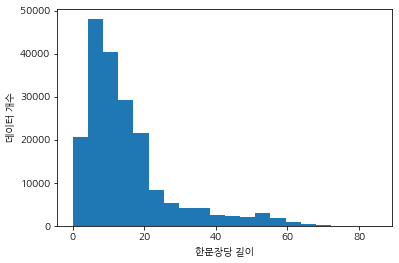

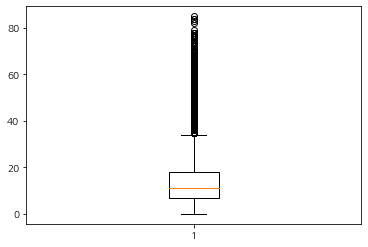

In [7]:
## 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
total_data_text_dist = [len(x) for x in total_data_text]
#print(total_data_text_dist)

mean = round(np.mean(total_data_text_dist),2)
std = round(np.std(total_data_text_dist),2)
max = np.max(total_data_text_dist)
min = np.min(total_data_text_dist)
min_count = len([x for x in total_data_text_dist if x == 0])
print("문장길이평균:",mean)
print("문장길이표준편차:",std)
print("문장길이Max:",max)
print("문장길이Min:",min)
print("문장길이 0개수:", min_count)

# 히스토그램 시각화: total_data
print(plt.rcParams['font.family'])
plt.rc('font',family='NanumGothic')
plt.hist(total_data_text_dist, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

# 박스플롯: total_data
plt.boxplot(total_data_text_dist)
plt.show()

##### (2) 적절한 최대 문장 길이 지정: 39

표준편차 +- 2범위내 데이터수: 182439 원래전체데이터대비비중: 93.51 %


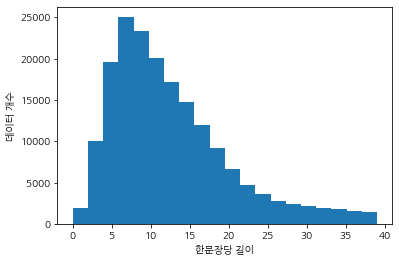

적절한 최대 문장 길이 >> pad_sequences maxlen:  39


In [8]:
## 적절한 최대 문장 길이 지정: (평균 + 표준편차*2)이내
total_data_text_dist_array = np.array(total_data_text_dist)
total_data_text_within_2std = total_data_text_dist_array[(total_data_text_dist_array <= mean + std*2) & (total_data_text_dist_array >= mean - std*2)]
print("표준편차 +- 2범위내 데이터수:", len(total_data_text_within_2std),
      "원래전체데이터대비비중:",round(len(total_data_text_within_2std)*100/len(total_data_text),2),"%")

# 히스토그램 시각화: total_data_text_within_2std
plt.hist(total_data_text_within_2std, bins = 20)
plt.xlabel('한문장당 길이')
plt.ylabel('데이터 개수')
plt.show()

max_length = int(mean + std*2)
print("적절한 최대 문장 길이 >> pad_sequences maxlen: ",int(max_length))

##### (3) word_to_index 및 index_to_word 보정:  앞쪽 위치  0,1,2번에   3개 항목 입력

In [9]:
# word_to_index의 첫 인덱스위치에 '<BOS>' 있는지 확인
print("word_to_index_앞쪽 10개 확인:",[[key,value] for key,value in word_to_index.items()][:10] )

print("len(word_to_index)",len(word_to_index))   # 3개가 비어있슴

word_to_index_앞쪽 10개 확인: [['', 3], ['.', 4], ['영화', 5], ['다', 6], ['고', 7], ['하', 8], ['을', 9], ['보', 10], [',', 11], ['게', 12]]
len(word_to_index) 9997


In [10]:
# <BOS>, <PAD>,  <UNK> 3항목에 인덱스 0,1,2  보정값 입력
word_to_index["<BOS>"] = int(0)
word_to_index["<PAD>"] = int(1)
word_to_index["<UNK>"] = int(2)  # unknown
print("word_to_index_추가된 항목 재확인:",[[key,value] for key,value in word_to_index.items()][-5:] )

# index_to_word 도 보정
index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])     # '<BOS>' 가 출력
print(word_to_index[''])  # 3 이 출력
print(index_to_word[4])     # '.' 가 출력

# 보정 후 x_train[0] 데이터 확인: 
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print(len(X_train[0]))
print(index_to_word[y_train[0]])
print("보정완료 OK")

word_to_index_추가된 항목 재확인: [['금기', 9998], ['부셔', 9999], ['<BOS>', 0], ['<PAD>', 1], ['<UNK>', 2]]
<BOS>
3
.
더 빙 진짜 짜증 나 네요 목소리
라벨:  0
8
<BOS>
보정완료 OK


##### (4) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [11]:
### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 및 max_length로 일정길이 맞춤
print("len(word_to_index):",len(word_to_index))
print("X_train", X_train[:3], len(X_train), type(X_train[0][0]))

# type 확인: train 내의 word index의 type check: 모두 int 임, 총개수 2,176,140개
floatlist = [];intlist = [];strlist = [];etclist = []
for X in X_train:
    for idx in X:
        if type(idx) == float:
            floatlist.append(idx)            
        elif type(idx) == int:
            intlist.append(idx)  
        elif type(idx) == str:
            strlist.append(idx)   
        else:
            etclist.append(idx)
print("X_train 내의 인덱스 type확인:","float",len(floatlist),"int",len(intlist),"str",len(strlist),
       "etc",len(etclist),"총개수", len(floatlist)+ len(intlist)+ len(strlist)+len(etclist)) # int만 총개수 2,176,140


# 숫자로 변환된 텍스트 데이터를 numpy array로 변경. 
X_train = np.array(X_train, dtype='object')
X_test = np.array(X_test, dtype='object')

## padding된 데이터: padding된 곳은 1 이 입력됨
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'], # <PAD> index 값 : 1
                                                       padding='pre',           # 성능향상위해 'pre'적용
                                                       maxlen=max_length)       # maxlen = 39
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'], # <PAD> index 값 : 1
                                                       padding='pre',           # 성능향상위해 'pre'적용
                                                       maxlen=max_length)       # maxlen = 39
print("X_train:", X_train[:3],X_train.shape)
print("X_test:", X_test[:3],X_test.shape)


len(word_to_index): 10000
X_train [[31, 70, 869, 38, 223, 19, 32, 723], [994, 503, 535, 662, 5, 117, 1591, 52, 894, 975, 14, 43, 376], [23, 201, 3]] 146026 <class 'int'>
X_train 내의 인덱스 type확인: float 0 int 2176140 str 0 etc 0 총개수 2176140
X_train: [[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1   31   70  869   38  223   19   32  723]
 [   1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1  994  503
   535  662    5  117 1591   52  894  975   14   43  376]
 [   1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1   23  201    3]] (146026, 39)
X_test: [[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1   

### 4. 모델 구성 및 validation set 구성

##### 모델은 3가지 이상 다양하게 구성

In [12]:
## Hyper param 설정
vocab_size = len(word_to_index)   # 어휘 사전의 크기(10,000개의 단어)

word_vector_dim = 16  # 워드 벡터의 차원 수
hidden_unit = 16
drop_rate = 0.2
cnn_dense_hidden_unit = 8
cnn_filter = 7
cnn_maxpool = 4
epochs= 20 


#### (1) LSTM 모델

In [13]:
## LSTM 모델

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.LSTM(hidden_unit)) 
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(tf.keras.layers.Dense(hidden_unit, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 162,401
Trainable params: 162,401
Non-trainable params: 0
__________________________________________________

#### (2) GRU 모델

In [14]:
## GRU 모델

model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gru.add(tf.keras.layers.Dropout(drop_rate))
model_gru.add(tf.keras.layers.GRU(hidden_unit))
model_gru.add(tf.keras.layers.Dropout(drop_rate))
model_gru.add(tf.keras.layers.Dense(hidden_unit, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = tf.keras.callbacks.ModelCheckpoint('/aiffel/aiffel/sentiment_classification/model/GRU_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
gru (GRU)                    (None, 16)                1632      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 161,921
Trainable params: 161,921
Non-trainable params: 0
________________________________________________

#### (3) CNN 모델

In [15]:
## CNN_1D 모델

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Dropout(drop_rate))
model_cnn.add(tf.keras.layers.Conv1D(hidden_unit,cnn_filter, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(cnn_maxpool))
model_cnn.add(tf.keras.layers.Conv1D(hidden_unit,cnn_filter, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D())
model_cnn.add(tf.keras.layers.Dropout(drop_rate))
model_cnn.add(tf.keras.layers.Dense(cnn_dense_hidden_unit, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 16)         

#### (4) GlobalMaxPooling1D 모델

In [16]:
## GlobalMaxPooling1D() 모델

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dropout(drop_rate))
model_gmp.add(tf.keras.layers.Dense(hidden_unit, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_gmp.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


##### (5) validation set 구성: train 80%,  valid 20%

In [17]:
## 총 train data rotn
print("X_train 총개수:", len(X_train), "80%분리: ",int(len(X_train)*0.8), "20%분리:",len(X_train)-int(len(X_train)*0.8))
train_len = int(len(X_train)*0.8)
valid_len = len(X_train)-int(len(X_train)*0.8)

# validation set 20% 분리: 
X_val = X_train[:valid_len]   
y_val = y_train[:valid_len]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[valid_len:]  
partial_y_train = y_train[valid_len:]

print("partial_X_train",len(partial_X_train),"partial_y_train",len(partial_y_train))
print("X_val",len(X_val), "y_val",len(y_val))

X_train 총개수: 146026 80%분리:  116820 20%분리: 29206
partial_X_train 116820 partial_y_train 116820
X_val 29206 y_val 29206


### 5. 모델 학습 개시 :  4개 모델


##### (1) LSTM모델 학습

In [18]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
  
history_lstm = model_lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.4791 - accuracy: 0.7817 - val_loss: 0.3579 - val_accuracy: 0.8416
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3485 - accuracy: 0.8519 - val_loss: 0.3508 - val_accuracy: 0.8456
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3300 - accuracy: 0.8613 - val_loss: 0.3448 - val_accuracy: 0.8498
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3199 - accuracy: 0.8676 - val_loss: 0.3476 - val_accuracy: 0.8478
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3101 - accuracy: 0.8709 - val_loss: 0.3470 - val_accuracy: 0.8487
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3029 - accuracy: 0.8739 - val_loss: 0.3476 - val_accuracy: 0.8471
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2950 - accuracy: 0.8774 - val_loss: 0.3512 - val_accuracy: 0.8488
Epoch 

##### (2) GRU 모델 학습

In [19]:
# GRU 모델
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
  
history_gru = model_gru.fit(partial_X_train, partial_y_train, epochs=epochs, callbacks=[es, mc], 
                           batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 7ms/step - loss: 0.4912 - accuracy: 0.7671 - val_loss: 0.3578 - val_accuracy: 0.8436

Epoch 00001: val_accuracy improved from -inf to 0.84363, saving model to /aiffel/aiffel/sentiment_classification/model/GRU_model.h5
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3506 - accuracy: 0.8522 - val_loss: 0.3471 - val_accuracy: 0.8493

Epoch 00002: val_accuracy improved from 0.84363 to 0.84935, saving model to /aiffel/aiffel/sentiment_classification/model/GRU_model.h5
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3334 - accuracy: 0.8606 - val_loss: 0.3483 - val_accuracy: 0.8491

Epoch 00003: val_accuracy did not improve from 0.84935
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3224 - accuracy: 0.8664 - val_loss: 0.3510 - val_accuracy: 0.8489

Epoch 00004: val_accuracy did not improve from 0.84935
Epoch 5/20
229/229 [==============================]

##### (3) CNN모델 학습

In [20]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
  
history_cnn = model_cnn.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 7ms/step - loss: 0.5713 - accuracy: 0.6816 - val_loss: 0.3946 - val_accuracy: 0.8247
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3843 - accuracy: 0.8330 - val_loss: 0.3652 - val_accuracy: 0.8360
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3502 - accuracy: 0.8515 - val_loss: 0.3615 - val_accuracy: 0.8381
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3278 - accuracy: 0.8614 - val_loss: 0.3629 - val_accuracy: 0.8396
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3086 - accuracy: 0.8716 - val_loss: 0.3624 - val_accuracy: 0.8407
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2908 - accuracy: 0.8796 - val_loss: 0.3679 - val_accuracy: 0.8385
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2740 - accuracy: 0.8875 - val_loss: 0.3763 - val_accuracy: 0.8371
Epoch 

##### (4) GlobalMaxPooling1D 모델 학습

In [21]:
model_gmp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
  
history_gmp = model_gmp.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.5739 - accuracy: 0.7323 - val_loss: 0.4134 - val_accuracy: 0.8166
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3996 - accuracy: 0.8227 - val_loss: 0.3646 - val_accuracy: 0.8378
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3598 - accuracy: 0.8450 - val_loss: 0.3558 - val_accuracy: 0.8429
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3382 - accuracy: 0.8556 - val_loss: 0.3543 - val_accuracy: 0.8427
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3239 - accuracy: 0.8629 - val_loss: 0.3556 - val_accuracy: 0.8432
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3107 - accuracy: 0.8694 - val_loss: 0.3573 - val_accuracy: 0.8438
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3034 - accuracy: 0.8722 - val_loss: 0.3612 - val_accuracy: 0.8438
Epoch 

### 6. test data 로 모델별 성능평가

#### (1) LSTM 모델

In [22]:
## LSTM 모델 성능평가
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print("results_lstm", results_lstm)

1534/1534 - 3s - loss: 0.4333 - accuracy: 0.8416
results_lstm [0.433331161737442, 0.8415777087211609]


#### (2) GRU 모델

In [23]:
## GRU 모델 성능평가
loaded_model_gru = tf.keras.models.load_model('/aiffel/aiffel/sentiment_classification/model/GRU_model.h5')
results_gru =loaded_model_gru.evaluate(X_test,  y_test, verbose=2)

print("results_gru", results_gru)

1534/1534 - 3s - loss: 0.3603 - accuracy: 0.8437
results_gru [0.3602946102619171, 0.8436965346336365]


#### (3) CNN 모델

In [24]:
## CNN 모델 성능평가
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)

print("results_cnn", results_cnn)

1534/1534 - 3s - loss: 0.4912 - accuracy: 0.8245
results_cnn [0.49117428064346313, 0.824545681476593]


#### (4) GlobalMaxPooling 모델

In [25]:
## GlobalMaxPooling 모델 성능평가
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)

print("results_gmp", results_gmp)

1534/1534 - 2s - loss: 0.4058 - accuracy: 0.8332
results_gmp [0.40577834844589233, 0.8331839442253113]


### 7. 모델별 Loss, Accuracy 그래프 시각화

#### (1) LSTM 모델

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


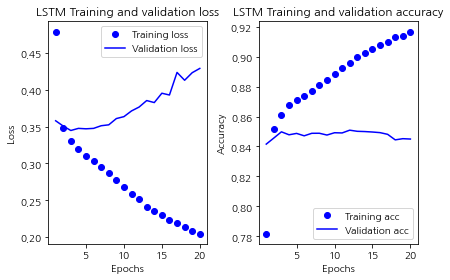

In [26]:
history_lstm = history_lstm.history
print(history_lstm.keys()) 

acc = history_lstm['accuracy']
val_acc = history_lstm['val_accuracy']
loss = history_lstm['loss']
val_loss = history_lstm['val_loss']

epochs = range(1, len(acc) + 1)

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACCURACY
#plt.clf()   # 그림을 초기화합니다
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### (2) GRU 모델

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


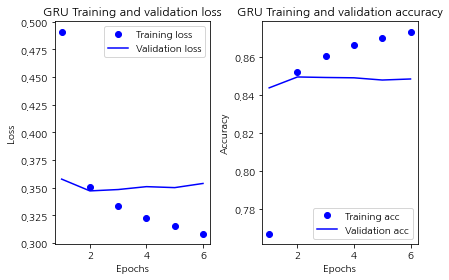

In [27]:
history_gru = history_gru.history
print(history_gru.keys()) 

acc = history_gru['accuracy']
val_acc = history_gru['val_accuracy']
loss = history_gru['loss']
val_loss = history_gru['val_loss']

epochs = range(1, len(acc) + 1)

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACCURACY
#plt.clf()   # 그림을 초기화합니다
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GRU Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### (3) CNN 모델

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


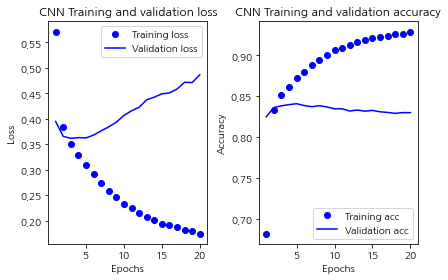

In [28]:
history_cnn = history_cnn.history
print(history_cnn.keys()) 

acc = history_cnn['accuracy']
val_acc = history_cnn['val_accuracy']
loss = history_cnn['loss']
val_loss = history_cnn['val_loss']

epochs = range(1, len(acc) + 1)

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACCURACY
#plt.clf()   # 그림을 초기화합니다
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### (4) GlobalMaxPooling 모델

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


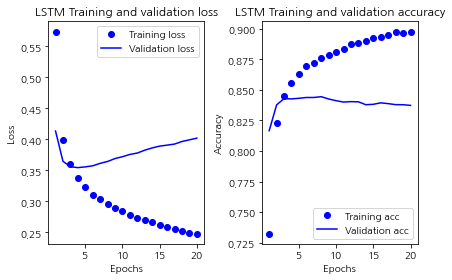

In [29]:
history_gmp = history_gmp.history
print(history_gmp.keys()) 

acc = history_gmp['accuracy']
val_acc = history_gmp['val_accuracy']
loss = history_gmp['loss']
val_loss = history_gmp['val_loss']

epochs = range(1, len(acc) + 1)

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ACCURACY
#plt.clf()   # 그림을 초기화합니다
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### 8. 학습된 Embedding Layer 분석

##### 학습된  Embedding 레이어분석은 4개모델 공통이므로, 시계열 대표모델인 LSTM모델것으로 사용함

In [30]:
## 위에서 학습된 LSTM Embedding레이어의 가중치fmf 별도변수에 저장 
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


##### (1) 학습된 Naver 영화리뷰 Embedding 레이어의 가중치파라메터를 sentiment_classification/data/word2vec_review.txt 파일로 저장

In [31]:
# 학습한 Embedding 파라미터를 파일에 써서 저장: sentiment_classification/data/word2vec.txt
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_review.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 9996개의 벡터를 얼마 16차원 사이즈로 기재할지 타이틀을 씀
print("vocab_size-4:   ",vocab_size-4 ,"word_vector_dim:   ",word_vector_dim)

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    if i%2000 == 0:
        # i == 20000번마다 한번씩 프린트
        print("i",i, "   index_to_word[i]:   ",index_to_word[i],
              "   ' '.join(map(str, list(vectors[i, :]))):   ", ' '.join(map(str, list(vectors[i, :]))))
f.close()

vocab_size-4:    9996 word_vector_dim:    16
i 2000    index_to_word[i]:    하늘    ' '.join(map(str, list(vectors[i, :]))):    -0.08510645 0.026787367 0.05315216 -0.027269002 -0.033731762 0.012788573 -0.1763829 0.08992536 -0.08403263 -0.07134669 -0.08440052 0.027051046 -0.16184738 0.050130527 -0.053817432 0.00040663866
i 4000    index_to_word[i]:    애쓰    ' '.join(map(str, list(vectors[i, :]))):    0.15690735 0.06443951 -0.0932269 -0.010170779 0.052761223 -0.098538816 0.1764295 -0.12253826 -0.12934574 0.07112555 -0.10723549 0.09801276 0.304164 0.07352814 0.19027406 -0.07608477
i 6000    index_to_word[i]:    죄악    ' '.join(map(str, list(vectors[i, :]))):    -0.14229505 0.169125 -0.07508739 -0.023661781 0.06510741 -0.03606304 0.022403838 -0.039189484 0.035572685 -0.03513212 -0.2553478 0.013558965 0.029585227 0.06703228 0.10047757 0.0012722787
i 8000    index_to_word[i]:    푸하하    ' '.join(map(str, list(vectors[i, :]))):    0.14030655 0.19098844 -0.04504888 -0.15801325 -0.07312924 0.010841

#####  (2) 파일로 저장된 학습된 Naver 영화리뷰 Embedding 레이어를 gensim을 이용해서, 읽어옴

In [32]:
## 저장된 Naver 영화리뷰 임베딩레이어 가중치파라메터를 읽어서 word vector로 활용

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors_simple['봄']
print('봄_vector', vector)
vector = word_vectors_simple['겨울']
print('겨울_vector', vector)


봄_vector [-0.05266168  0.11970079  0.01575396 -0.04131782  0.02580307 -0.07703467
  0.00636575  0.08058766  0.01872723 -0.0661723  -0.03009054 -0.02375824
 -0.03910924 -0.0690389  -0.01724928  0.02272314]
겨울_vector [-0.24558601 -0.11893274  0.0831153   0.16231097  0.12992293 -0.17516723
 -0.0433318   0.06614636  0.0520519  -0.06977977  0.00370081 -0.18016317
 -0.07395176 -0.0828924  -0.04811688  0.08205345]


##### (3) similar_by_word등 학습된 임베딩레이어 테스트

  ###### similar_by_word 테스트 결과:     8단어를 테스트 해봤는데,'하정우' 1개 단어외는 모두 존재하지 않아서, key오류가 났으며, '하정우'도 별로 유사하지 않은 단어들만 검색됨 ===> 아직 학습이 덜 된것으로 보임
  -similar_by_word: 인공지능, 하정우, 미분, 삼성전자,막걸리 5단어검색결과 하정우만 검색되었는데, 거의 비슷하지 않은 단어들이 매칭됨 

  -most_similar: positive=['웃음', '기쁨'], negative=['슬픔']으로 해봤는데, 단어들이 없어 key 오류나서, 코드 실행결과생략

  -distance: ("짜장면", "짜장면") ("개울", "비트코인")의 거리측정해 봤는데, key오류 나서, 코드 실행결과생략

  -검토의견: 임베딩이 학습이 덜되어있는 것으로 보임

In [33]:
# similar_by_word등 테스트

word_vectors_simple.similar_by_word("하정우")

[('탔', 0.9507845640182495),
 ('새로운', 0.9351289868354797),
 ('빠질', 0.927410364151001),
 ('스타크래프트', 0.9264448285102844),
 ('검색어', 0.9214419722557068),
 ('이럼', 0.9210147261619568),
 ('주제가', 0.9151312112808228),
 ('끈끈', 0.9139918684959412),
 ('이틀', 0.910378634929657),
 ('후속', 0.909903883934021)]

### 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.

한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.

참고 링크1: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models

참고 링크2: https://radimrehurek.com/gensim/models/keyedvectors.html

##### (1) 사전학습된 embedding layer 인 word2vec_ko.model

###### voca size 총 302,960 단어존재, dim 100차원

In [34]:
### 한국어 word2vec 모델: word2vec_ko.model
from gensim.models.keyedvectors import Word2VecKeyedVectors 

word2vec_ko_model_path = os.getenv('HOME')+ '/data/word2vec_ko.model'  

word_vectors = Word2VecKeyedVectors.load(word2vec_ko_model_path)
vector = word_vectors.wv['끝']
print('끝_vector', vector)

끝_vector [ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7

##### (2) similar_by_word 등으로  word2vec_ko.model테스트: 

아래 코드셀에서 보듯이 8단어를 위 7-(3)에서와 동일하게 해봤는데,상당히 관련성이 있게 매칭된 단어들이 검색됨

-similar_by_word: 인공지능, 하정우, 미분, 삼성전자,막걸리 5단어검색결과 모두 유사단어 매칭됨 

-most_similar: positive=['웃음', '기쁨'], negative=['슬픔']으로 해봤는데, 상당히 유사한 '즐거움'으로 나오며, 유사도 0.7928로 높음

-distance: ("짜장면", "짜장면"): 0.0 으로 동일하다는 의미임 //   ("개울", "비트코인"): 1.2 로 관련성이 멀다는 의미

##### 비교 검토의견:   7)의 자체 학습한 모델이 비해, 8)의 한국어 word2vec_ko.model은 상당히 관련성및 유사도 매칭학습이 잘되어있는 것으로 보임

In [35]:
# shape
word_vectors.wv.vectors.shape

# similar_by_word 테스트
vector = word_vectors.wv.similar_by_word('인공지능')
print('인공지능_vector',vector)
vector = word_vectors.wv.similar_by_word("하정우")
print('하정우_vector',vector)
vector = word_vectors.wv.similar_by_word("미분")
print('미분_vector',vector)
vector = word_vectors.wv.similar_by_word("삼성전자")
print('삼성전자_vector',vector)
vector = word_vectors.wv.similar_by_word("막걸리")
print('막걸리_vector',vector)

# most_similar / similarity
result = word_vectors.wv.most_similar(positive=['웃음', '기쁨'], negative=['슬픔'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

# distance
distance = word_vectors.wv.distance("짜장면", "짜장면")
print(f"{distance:.1f}")
distance = word_vectors.wv.distance("개울", "비트코인")
print(f"{distance:.1f}")

인공지능_vector [('AI', 0.8461811542510986), ('컴퓨팅', 0.789376437664032), ('가상현실', 0.7639996409416199), ('컴퓨터', 0.7492972016334534), ('IT', 0.7431951761245728), ('블록체인', 0.7353136539459229), ('솔루션', 0.7322530150413513), ('기술', 0.72092604637146), ('로봇', 0.7138661742210388), ('ICT', 0.7124600410461426)]
하정우_vector [('설경구', 0.8356397747993469), ('이병헌', 0.8288198113441467), ('임청하', 0.8188225626945496), ('조재현', 0.8113486170768738), ('김희애', 0.8106188774108887), ('황정민', 0.8098660111427307), ('이범수', 0.8093218207359314), ('이덕화', 0.8078502416610718), ('송강호', 0.7987250685691833), ('최지우', 0.7953410744667053)]
미분_vector [('적분', 0.8656334280967712), ('다항식', 0.8072242736816406), ('복소수', 0.7974129319190979), ('곱셈', 0.7951776385307312), ('함수', 0.788821280002594), ('텐서', 0.7794451117515564), ('벡터', 0.7712417840957642), ('도함수', 0.7653661370277405), ('연산자', 0.7596789002418518), ('편미분', 0.7555026412010193)]
삼성전자_vector [('KT', 0.7436059713363647), ('LG', 0.729961633682251), ('삼성', 0.7171362638473511), ('애플', 0.

### (3) word2vec_ko.model을 [[ LSTM모델 ]] 의 임베딩레이어의 초기화가중치로 사용

In [36]:
vocab_size = 10000    # 자체학습모델과 동일하게 설정(10,000개의 단어)
word_vector_dim = 100  # 한국어 word2vec_ko.model의 벡터차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
        
print("embedding_matrix",embedding_matrix[:1],embedding_matrix.shape)   # (10000,100)    
        

embedding_matrix [[1.99491665e-01 1.73960515e-01 6.59555121e-02 4.48212716e-01
  3.28879409e-01 3.34866149e-01 8.81768567e-01 3.67951060e-01
  2.47002338e-01 3.50364716e-01 8.45663482e-01 4.19736638e-01
  7.47475874e-01 6.30289818e-01 7.18551638e-01 7.49268958e-01
  1.14044899e-01 4.45133635e-01 7.97064406e-01 5.62423913e-01
  1.38710365e-01 8.48931638e-01 3.77854946e-01 8.18532736e-01
  6.09119006e-01 8.65925031e-01 9.69232392e-01 7.22264175e-01
  4.89081046e-01 9.86238168e-01 3.39541540e-01 9.53202291e-01
  5.28441947e-01 1.24529440e-01 3.81780373e-01 9.80519044e-01
  5.61808870e-01 7.90993413e-02 7.74811727e-01 2.92000962e-01
  6.28310581e-01 7.56039597e-01 7.13738026e-01 2.89042422e-01
  1.79962074e-01 5.94949863e-01 6.12637187e-01 2.33102458e-01
  3.89151802e-01 9.79618013e-01 4.16447378e-01 9.76209839e-01
  7.86312068e-01 6.35973017e-01 1.61310600e-01 6.07348773e-01
  4.15787874e-01 1.11330917e-01 4.08231899e-01 1.42986289e-01
  2.53002711e-01 5.86025026e-01 7.02018300e-01 3.4226

#### (4) [[  LSTM모델구성및 학습 ]]

In [37]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 구성: LSTM 모델
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_length,         # 39
                                 trainable=True,                   # trainable을 True로 주면 Fine-tuning
                                 ))  
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.LSTM(16)) 
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(16, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 39, 100)           1000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 39, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,007,777
Trainable params: 1,007,777
Non-trainable params: 0
____________________________________________

In [39]:
# 학습의 진행
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
epochs=  20 
history_lstm = model_lstm.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)


Epoch 1/20
229/229 [==============================] - 3s 8ms/step - loss: 0.6064 - accuracy: 0.6614 - val_loss: 0.4802 - val_accuracy: 0.7745
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4810 - accuracy: 0.7733 - val_loss: 0.4079 - val_accuracy: 0.8164
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4285 - accuracy: 0.8051 - val_loss: 0.3816 - val_accuracy: 0.8308
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4021 - accuracy: 0.8199 - val_loss: 0.3647 - val_accuracy: 0.8393
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3835 - accuracy: 0.8283 - val_loss: 0.3576 - val_accuracy: 0.8434
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3684 - accuracy: 0.8376 - val_loss: 0.3522 - val_accuracy: 0.8465
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3588 - accuracy: 0.8432 - val_loss: 0.3482 - val_accuracy: 0.8494
Epoch 

#### (5) LSTM 모델성능 테스트

##### 전이학습결과 성능개선됨

##### Test Accuracy : 85.61%

In [40]:
## test data 로 성능평가
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1534/1534 - 3s - loss: 0.3465 - accuracy: 0.8562
[0.34652310609817505, 0.8561649322509766]


## 회고

본 프로젝트는 Naver 영화리뷰 텍스트 감성분석하기이며, 자연어처리과정을 처음단계부터, 기학습된 임베딩레이어로 전이학습을 해보는 최종단계
까지로 구성됩니다.

먼저, Naver 영화리뷰데이터 총 200000개(train data 150000,test data 50000)를 로드하였고, 데이터로더함수를 만들었습니다.
특히, 함수내에 들어갈 데이터를 정제하기위해서, 별도의 셀을 할애해서, 필요없는 특수문자, 긴공백, 그리고, 한글과 숫자외에는
정규표현식을 사용하여,비교적 깔끔하게 정리될수 있게끔 노력하였습니다

그리고, 데이터로드함수에는 1. 데이터의 중복 제거/ 2. NaN 결측치 제거 / 3. 데이터 정제 
/4. 한국어 토크나이저로 토큰화(Mecab사용하여 토큰화진행했슴)/5. 불용어(Stopwords) 제거 / 6.사전word_to_index 구성 
/7. 텍스트 스트링을 사전 인덱스 스트링으로 변환등의 7가지를 처리할수 있도록 한가지한가지 테스트를 해가며,코딩을 하였습니다

이렇게 만들어진  데이터로드함수를 통해서, voca size는 10000개,train data는 150000개에서 146026개로 축소정리되었고,
test data는 50000개에서 49084개로 축소정리되었습니다.
voca size는 10000개이지만, 나중에 3개의 필수단어를 입력시키기위해서, 9997개의 word_to_index, index_to_word를 만들었습니다.

모델구성을 위한 데이터분포를 분석해 보았는데, 전체 데이터의 문장길이평균은 14.9자였으며,표준편차는 12.27자, 최대길이는 85자였습니다
분포의 대부분은 20자이하였고, 적절한 데이터분포를 위해서, 이상치를 제거하고, 적절한 최대길이를 구하기위해서,
수업에서 배운대로, 최대치를 평균 + 2*표준편차까지로 정하기로 하였습니다. 
이 범위내에 드는 데이터수는 182439개로서, 원래 전체 데이터수의 93.51%로서, 적절해 보입니다.

이렇게 해서 구한, '적절한 최대 문장 길이'(pad_sequences maxlen)는  39개였습니다.
그리고, 위에서,word_to_index, index_to_word에서 3개가 부족했던 것을  <BOS>,<PAD>,<UNK> 로
word_to_index 및 index_to_word 보정처리하여,Voca size는 10000개로 채웠습니다.
그러한 후에,'적절한 최대 문장 길이'(pad_sequences maxlen)인 39개보다 작은 문장들은 동일한 길이를 맞추기위해서, padding처리를 했습니다

이제 모델 구성및 validation set 구성을 해도 되는 단계에 왔고, 모델은 LSTM, GRU, CNN, GlobalMaxPooling 모델의 4가지를
구성해서 테스트해보았습니다.(GRU 모델은 공부차원에서, Early stopping을 적용해보았습니다)
모델구조는 대부분 히든유닛을 16개로 하고, dropout layer를 모델별로 2개씩 집어 넣어서, 오버피팅을 방지했습니다.

이렇게 해서 나온 Metric들은 4개 보델별로 헉습과정을 볼수 있도록 시각화하였습니다.

모델별로 test data를 통한 Accuracy는,
    
1.LSTM모델: 0.8415
    
2.GRU모델: 0.8437
    
3.CNN모델: 0.8245
    
4.GlobalMaxPooling모델:0.8332
    
로서, 4개 모델 모두 85%를 넘기지 못했습니다. 

LSTM, GRU, CNN, GlobalMaxpooling 모델의 성능이 큰차이가 않나는 것이
눈에 띄여서, 앞으로는 시계열데이터라도, 여러 모델들을 적용해 보아야겠다는 생각이 들었습니다. 

이렇게 해서, 모델별 Naver영화리뷰 긍정,부정반응 예측 성능평가는 1차 마무리하고서, 이러한 감성분석모델의
중요한 기본이 되는 embedding layer의 중요성을 알아보겠습니다.

먼저, 위에서 학습한 4개 모델중에서, 전통적으로 시계열처리의 대표주자인 LSTM모델의 embedding layer의 단어의미기준 매칭이
잘되어있는지를 보고서, 전문적으로 학습된 embedding layer인 word2vec_ko_model과 비교해 보았습니다.

저장해놓았던 LSTM모델의 embedding layer의 가중치와 전문적으로 학습된 embedding layer인 word2vec_ko_model을
gensim.models.keyedvectors.Word2VecKeyedVectors를 통해서 가져왔고,이를 similar_by_word, most_similar,distance 3가지를
통해 비교해 봤습니다.
    
테스트단어는 인공지능, 하정우, 미분, 삼성전자,막걸리,(웃음,기쁨),(짜장면,짜장면),(개울,비트코인)의 8단어를 사용했는데,
LSTM모델의 embedding layer의 가중치모댈은 하정우만 검색되었는데, 그것마저도 관련성이 없는 단어들이었어서, 학습이 잘않되어 있다고
판단되었습니다.
    
반면,전문적으로 학습된 embedding layer인 word2vec_ko_model은 8개단어 모두 다 검색되었으며, 단어 유사도가 상당히 높은 것으로 보여,
학습이 잘되어있는 것으로 판단되었습니다.

##### 마지막으로,전문적으로 학습된 embedding layer인 word2vec_ko_model을 LSTM모델의 embedding layer에 초기화가중치로 초기화해서,
##### 전이학습을 시도해보았는데, epoch 20 및 다른 조간은 기존과 동일하게 하고서, 학습을 시키고, test data에 적용을 해보았는데,
##### test Accuracy 85.61%
#####    로 85%를 넘어섰습니다. 

결론적으로, 자연어처리는 embedding layer의 성능이 모델의 성능을 개선시켜주며, 중요한 영향을 준다는 것을 볼수있었습니다.
그리고, 앞으로는 시계열데이터라도, LSTM,GRU뿐이아니라, CNN등 여러 모델들을 함께 적용해서 비교해 보아야겠다는 생각이 듭니다. 
자연어처리에 다양한 경험을 해보는 그리고 앞으로의 자연어 공부에 초석이될 것으로 생각되는 유익하고, 좋은 강의였습니다.

#### 루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항 // 상세기준
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. // 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. // gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. // 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함